In [30]:
import torch
from torch import nn
from d2l import torch as d2l
import torch_n

In [31]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)
# train_data, train_iter,true_w,torch.norm(true_w)

## 多项式回归

In [32]:
import math
import torch
import numpy as np
from torch import nn
from d2l import torch as d2l

In [33]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)


In [34]:
true_w, true_w.shape

(array([ 5. ,  1.2, -3.4,  5.6,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ]),
 (20,))

In [35]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32)
                                           for x in [true_w, features,
                                                     poly_features, labels]]
features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.4197],
         [1.2459]]),
 tensor([[1.0000e+00, 4.1971e-01, 8.8079e-02, 1.2323e-02, 1.2930e-03, 1.0854e-04,
          7.5923e-06, 4.5522e-07, 2.3883e-08, 1.1138e-09, 4.6746e-11, 1.7836e-12,
          6.2384e-14, 2.0141e-15, 6.0381e-17, 1.6895e-18, 4.4319e-20, 1.0942e-21,
          2.5514e-23, 5.6360e-25],
         [1.0000e+00, 1.2459e+00, 7.7608e-01, 3.2230e-01, 1.0038e-01, 2.5013e-02,
          5.1937e-03, 9.2437e-04, 1.4395e-04, 1.9927e-05, 2.4827e-06, 2.8119e-07,
          2.9193e-08, 2.7977e-09, 2.4897e-10, 2.0679e-11, 1.6102e-12, 1.1800e-13,
          8.1675e-15, 5.3555e-16]]),
 tensor([5.5665, 5.7423]))

In [36]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]


In [37]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: # y_hat是矩阵
        y_hat = y_hat.argmax(axis=1) # 返回每一行中最大元素的索引
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [38]:
class Accumulator:
    """在`n`个变量上累加。"""
    def __init__(self, n):
        self.data = [0.0] * n
        
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

In [39]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期（定义见第3章）。"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确率总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练准确率
    return metric[0] / metric[2], metric[1] / metric[2]

In [40]:
def train(train_features, test_features, train_labels, test_labels, num_epochs = 400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                                 batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.013      1.2335088 -3.3897667  5.5109777]]


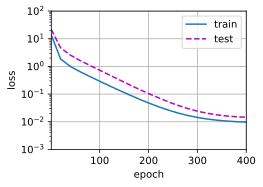

In [41]:
# 三阶多项式函数拟合（正常）
# 从多项式特征中选择前4个维度，即 1、x、x^2/2!、x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.5861657 3.002741 ]]


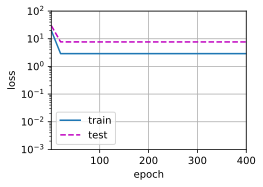

In [42]:
# 线性函数拟合（欠拟合）
# 从多项式特征中选择前2个维度，即 1、x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 5.0444627   1.381982   -3.5436246   4.8133044   0.34097886  1.3109179
   0.43319526  0.40665781 -0.02176849 -0.03390391 -0.20034829 -0.19104418
   0.10753144  0.04368108  0.04933854  0.15752593  0.03924454  0.1915854
  -0.08673761 -0.1342031 ]]


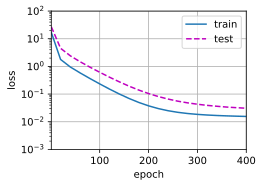

In [43]:
# 训练样本不足（过拟合）
# 从多项式特征中选择所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:])

weight: [[ 5.051886    1.3945838  -3.5920646   4.783087    0.5416727   1.2340854
   0.44813633 -0.09893076]]


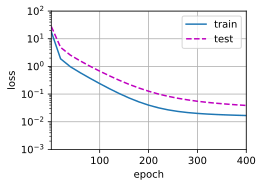

In [44]:
train(poly_features[:n_train, :8], poly_features[n_train:, :8],
      labels[:n_train], labels[n_train:])

## 权重衰减

In [45]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5   
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)
print('L2 norm of true_w:', torch.norm(true_w).item())

L2 norm of true_w: 0.1414213478565216


In [46]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [47]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2 # 对所有项求平方后再将它们求和

In [48]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 添加了L2范数惩罚项
            loss_ = loss(net(X), y) + lambd * l2_penalty(w)
            loss_.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
            
    #print("W=",w,"\nB=",b,"\n")
    print('L2 norm of w:', torch.norm(w).item())

L2 norm of w: 13.64729118347168


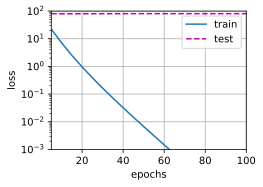

In [49]:
train(lambd=0) # 没有使用权重衰减

L2 norm of w: 0.3646872937679291


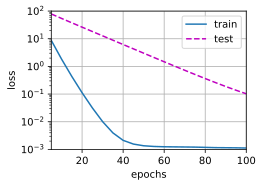

In [50]:
train(lambd=3) # 使用权重衰减

L2 norm of w: 0.028754854574799538


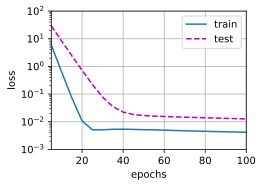

In [51]:
train(lambd=10) # 使用权重衰减

L2 norm of w: 0.01903686672449112


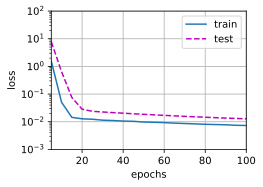

In [52]:
train(lambd=20) # 使用权重衰减

### 简洁实现

In [53]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    
    trainer = torch.optim.SGD([{
        "params":net[0].weight,
        "weight_decay":wd
    },{
        "params":net[0].bias,
        "weight_decay":0
    }], lr=lr)
    #print("W=",w,"\nB=",b,"\n")
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', net[0].weight.norm().item())

L2 norm of w: 0.37399742007255554


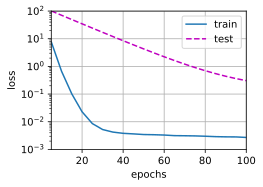

In [54]:
train_concise(3)

L2 norm of w: 0.03589574992656708


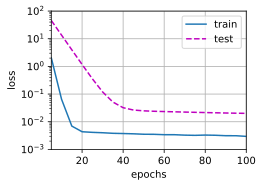

In [55]:
train_concise(10)

L2 norm of w: 0.02600042335689068


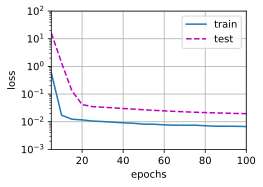

In [56]:
train_concise(20)

## 暂退法

In [57]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃。
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留。
    if dropout == 0:
        return X
    mask = (torch.Tensor(X.shape).uniform_(0, 1) > dropout).float()
    return mask * X / (1.0 - dropout)

In [58]:
X = torch.arange(16, dtype=torch.float32).reshape((2, 8))
X, dropout_layer(X, 0), dropout_layer(X, 0.5), dropout_layer(X, 1)


(tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11., 12., 13., 14., 15.]]),
 tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11., 12., 13., 14., 15.]]),
 tensor([[ 0.,  0.,  4.,  6.,  8., 10., 12.,  0.],
         [16., 18., 20., 22.,  0.,  0.,  0., 30.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]))

In [59]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

In [60]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
        
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out
    
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)
        

In [61]:
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数，预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel()) # y.numel()返回y中元素的个数
    return metric[0] / metric[1]



In [62]:
import util

In [63]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型（定义见第3章）

    Defined in :numref:`sec_softmax_scratch`"""
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [64]:
from d2l import torch as  d2l

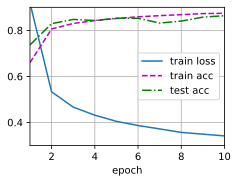

In [65]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [68]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 256), nn.ReLU(),
                    nn.Dropout(dropout1), nn.Linear(256, 256), nn.ReLU(),
                    nn.Dropout(dropout2), nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights);

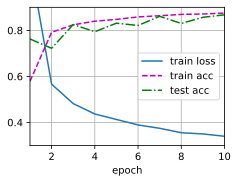

In [69]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)